In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

import pymc3 as pm
print(pm.__version__)
import patsy

C:\Miniconda3\envs\ppc\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


3.4.1


In [2]:
# generate dataset
mu = np.array([50, 80, 100])
sd = np.array([3, 5, 10])

n_samples = np.array([100, 150, 100])
factor_levels = np.array(['A', 'B', 'C'])

data = pd.DataFrame(data={
    'y':np.concatenate(
        (np.random.normal(loc=mu[0], scale=sd[0], size=n_samples[0]), 
         np.random.normal(loc=mu[1], scale=sd[1], size=n_samples[1]), 
         np.random.normal(loc=mu[2], scale=sd[2], size=n_samples[2]))
    ),
    'x':np.repeat(factor_levels, n_samples)
})

data.x = pd.Categorical(data.x, ordered=False)
data.head()

,x,y
0,A,51.851638
1,A,51.221628
2,A,52.954378
3,A,51.579115
4,A,49.553283


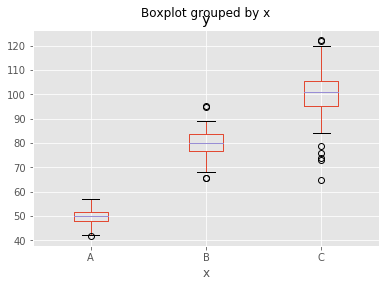

In [3]:
_ = data.boxplot(column='y', by='x')

In [4]:
## Treatment parametrization

In [5]:
# design matrix. Treatment (Dummy) Coding (see: https://onlinecourses.science.psu.edu/stat502/node/246)
_, X = patsy.dmatrices('y ~ 1 + x', data=data)
X

DesignMatrix with shape (350, 3)
  Intercept  x[T.B]  x[T.C]
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
          1       0       0
  [320 rows omitted]
  Terms:
    'Intercept' (column 0)
    'x' (columns 1:3)
  (to view full data

The coding of the design matrix $\mathbf{X}$ are interpreted as:

$\beta_A = \mu_A$

$\beta_B = \mu_B - \mu_A$

$\beta_C = \mu_C - \mu_A$

so, for example, the effect of *B* is:

$\mu_{B} = \beta_A + \beta_B$.

Similarly, for *C*:

$\mu_{B} = \beta_A + \beta_C$.

In [6]:
with pm.Model() as ANOVA_treatment_coding:
    
    beta = pm.Normal('beta', mu=0, sd=100, shape=(X.shape[1]))
    sd = pm.HalfCauchy('sd', beta=3, shape=(X.shape[1]))
    
    mu = pm.math.dot(np.asarray(X), beta)
    
    # the standard deviation is assumed to be different between groups. If I were to assume that instead the sd is the same
    # then I would see that the sampler would not converge properly
    y_likelihood = pm.Normal('y_likelihood', mu=mu, sd=sd[data.x.cat.codes], observed=data.y)
    
    trace = pm.sample(draws=3000, tune=1000, chains=4, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd_log__, beta]


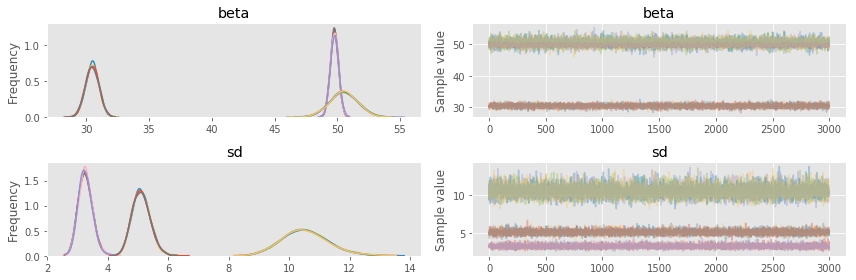

In [7]:
_ = pm.traceplot(trace)

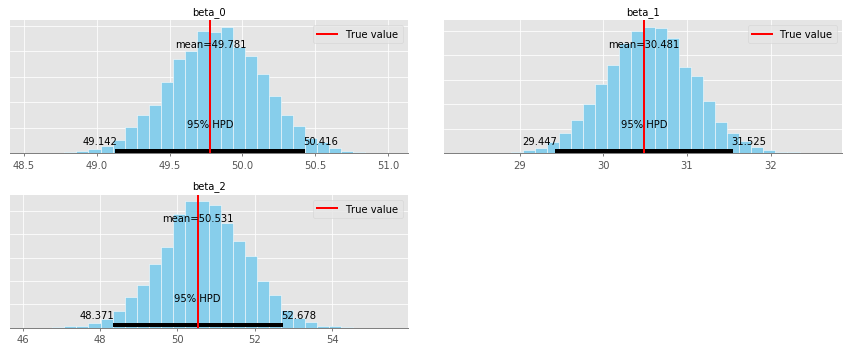

In [8]:
ax = pm.plot_posterior(trace, ['beta'])

data_grouped = data.groupby('x').mean()
ax[0].axvline(data_grouped.loc['A'].values, color='red', lw=2, label='True value')
ax[1].axvline(data_grouped.loc['B'].values - data_grouped.loc['A'].values, color='red', lw=2, label='True value')
ax[2].axvline(data_grouped.loc['C'].values - data_grouped.loc['A'].values, color='red', lw=2, label='True value')

ax[0].legend()
ax[1].legend()
ax[2].legend();

In [9]:
with ANOVA_treatment_coding:
    ppc = pm.sample_ppc(trace, samples=250)

100%|█████████████████████| 250/250 [00:00<00:00, 1656.71it/s]


In [10]:
ppc['y_likelihood'].shape

(250, 350)

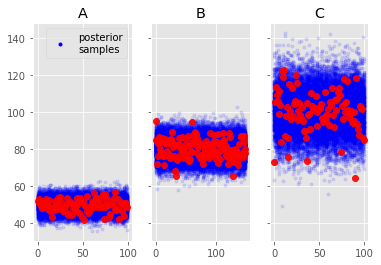

In [11]:
fig, ax = plt.subplots(1, len(data.x.unique()), sharey=True)

for i, x in enumerate(data.x.unique()):
    ax[i].plot(ppc['y_likelihood'].T[data.x==x], '.', alpha=0.1, color='blue')
    ax[i].plot(np.nan, '.', color='blue', label='posterior\nsamples')

    ax[i].plot(data.y[data.x==x].values, 'o', alpha=0.9, color='red')
    ax[i].set_title(x)
    
ax[0].legend()

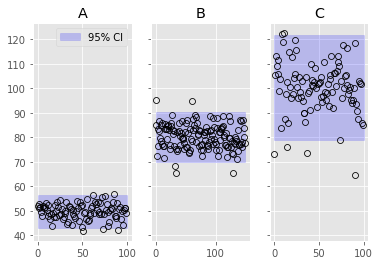

In [12]:
fig, ax = plt.subplots(1, len(data.x.unique()), sharey=True)

for i, x in enumerate(data.x.unique()):
    mu, sigma = ppc['y_likelihood'].T[data.x==x].mean(), ppc['y_likelihood'].T[data.x==x].std()*2 
    ax[i].fill_between([0, len(data.y[data.x==x])], mu-sigma, mu+sigma, alpha=0.2, color='blue', label='95% CI')
    ax[i].plot(data.y[data.x==x].values, 'o', markeredgecolor='black', markeredgewidth=0.8, markerfacecolor='None')
    ax[i].set_title(x)
    
ax[0].legend()

The posterior check suggests that the model fits the data well

## Effects parametrization

In [13]:
# design matrix. ´Effects model´ . The intercept is the grand mean, whereas the slope is the deviations of the factors levels
_, X = patsy.dmatrices('y ~ 0 + C(x, Sum)', data=data)
X

DesignMatrix with shape (350, 3)
  C(x, Sum)[mean]  C(x, Sum)[S.A]  C(x, Sum)[S.B]
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1               1               0
                1

The coding of the design matrix $\mathbf{X}$ are interpreted as the deviations of the means from their simple average ( https://cran.r-project.org/web/packages/codingMatrices/vignettes/codingMatrices.pdf ):

$\beta_0 = \frac{1}{p}\sum_{j=A...C}\mu_j = \bar\mu$

$\beta_A = \mu_A - \bar\mu$

$\beta_B = \mu_B - \bar\mu$

and $\beta_C$ can be derived post-hoc as $\beta_C = -\mu_B - \mu_A$, because of the sum-to-zero contraint $\sum_{j=A...C}\beta_j = 0$.

Finally, 

$\mu_j = \beta_0 + \beta_j$, with $j = A, B, C$

In [14]:
with pm.Model() as ANOVA_sum_coding:
    
    beta = pm.Normal('beta', mu=0, sd=100, shape=(X.shape[1]))
    sd = pm.HalfCauchy('sd', beta=5, shape=(X.shape[1]))
    
    mu = pm.math.dot(np.asarray(X), beta)
    
    # the standard deviation is assumed to be different between groups. If I were to assume that instead the sd is the same
    # then I would see that the ampler would not converge properly
    y_likelihood = pm.Normal('y_likelihood', mu=mu, sd=sd[data.x.cat.codes], observed=data.y)
    
    trace = pm.sample(draws=3000, tune=1000, chains=4, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd_log__, beta]


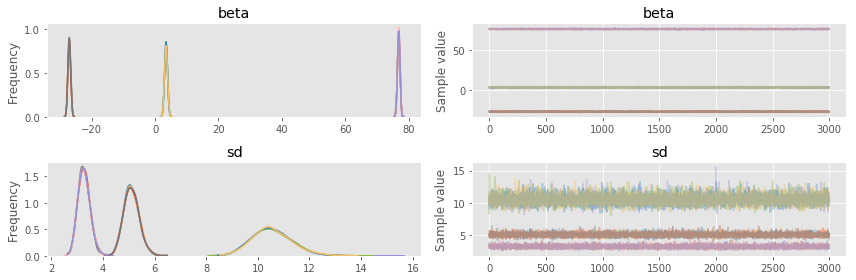

In [15]:
_ = pm.traceplot(trace)

In [16]:
# add deviation of C
beta_3 = - (trace['beta'][:, 1] + trace['beta'][:, 2])
trace.add_values({'beta_3':beta_3})

Grand mean = [76.78447205]
Levels mean = 
            y
x            
A   49.779156
B   80.264736
C  100.309524


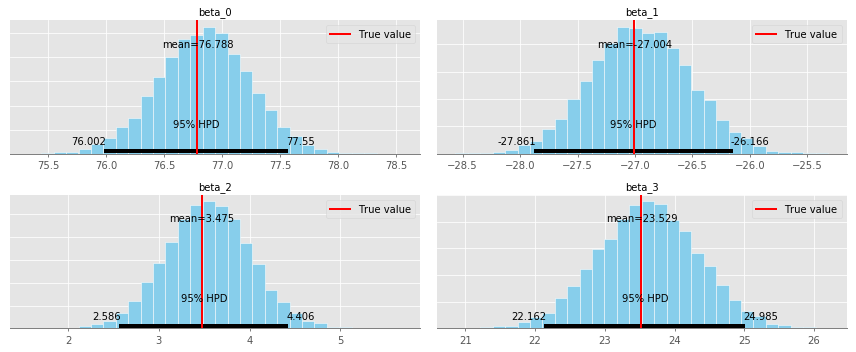

In [17]:
print('Grand mean = {}'.format(data.groupby(by='x').mean().mean().values))
print('Levels mean = ')
print(data.groupby(by='x').mean())

ax = pm.plot_posterior(trace, ['beta', 'beta_3'])

ax[0].axvline(data_grouped.mean().values, color='red', lw=2, label='True value')
ax[1].axvline(data_grouped.loc['A'].values - data_grouped.mean().values , color='red', lw=2, label='True value')
ax[2].axvline(data_grouped.loc['B'].values - data_grouped.mean().values, color='red', lw=2, label='True value')
ax[3].axvline(data_grouped.loc['C'].values - data_grouped.mean().values, color='red', lw=2, label='True value')

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend();

In [18]:
with ANOVA_sum_coding:
    ppc = pm.sample_ppc(trace, samples=250)

100%|█████████████████████| 250/250 [00:00<00:00, 1257.03it/s]


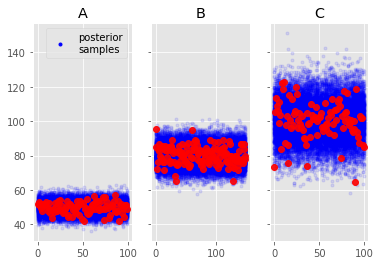

In [19]:
fig, ax = plt.subplots(1, len(data.x.unique()), sharey=True)

for i, x in enumerate(data.x.unique()):
    ax[i].plot(ppc['y_likelihood'].T[data.x==x], '.', alpha=0.1, color='blue')
    ax[i].plot(np.nan, '.', color='blue', label='posterior\nsamples')

    ax[i].plot(data.y[data.x==x].values, 'o', alpha=0.9, color='red')
    ax[i].set_title(x)
    
ax[0].legend()

The posterior check suggests that the model fits the data well

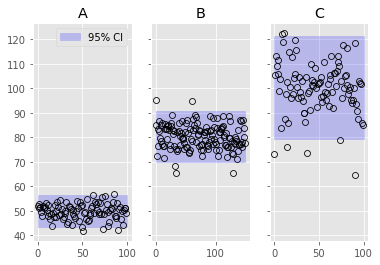

In [20]:
fig, ax = plt.subplots(1, len(data.x.unique()), sharey=True)

for i, x in enumerate(data.x.unique()):
    mu, sigma = ppc['y_likelihood'].T[data.x==x].mean(), ppc['y_likelihood'].T[data.x==x].std()*2 
    ax[i].fill_between([0, len(data.y[data.x==x])], mu-sigma, mu+sigma, alpha=0.2, color='blue', label='95% CI')
    ax[i].plot(data.y[data.x==x].values, 'o', markeredgecolor='black', markeredgewidth=0.8, markerfacecolor='None')
    ax[i].set_title(x)
    
ax[0].legend()